Ref: 
https://www.tensorflow.org/guide/keras/custom_layers_and_models
https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit

https://tf.wiki/zh_hant/preface.html

## The ODE example

The ODE equation is:

$$\frac{d\phi}{dt}+(t+\frac{1+3t^2}{1+t+t^3})\phi=t^3+2t+t^2\frac{1+3t^2}{1+t+t^3}$$

With the following condition:
$$\phi(0) = 1\quad and \quad t \in [0,1]$$

The analytic solution is:
    
$$\phi(t) = \frac{e^{-t^2}/2}{1+t+t^3}$$

In [11]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import time

print(tf.__version__)

2.3.1


# 1. Build model

## [Loss function](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_losses)

In [37]:
class ODE_Loss(tf.keras.losses.Loss):
    def __init__(self, regularization_factor=0.1, name="ODE_Loss"):
        super().__init__(name=name)

    def call(self, inputs, phi):
        phi_t = tf.gradients(phi, inputs)[0]

        governing_Eq = phi_t[1:]+(inputs[1:] + (1. + 3.*inputs[1:]**2) / (1. + inputs[1:] + inputs[1:]**3))*phi[1:] - \
                       (inputs[1:]**3 + 2.*inputs[1:] + inputs[1:]**2 * ((1. + 3.*inputs[1:]**2) / (1. + inputs[1:] + inputs[1:]**3)))

        loss = tf.reduce_mean(tf.square(governing_Eq)) + tf.reduce_mean(tf.square(phi[0]-1)) 

        return loss

## [Metric](https://www.tensorflow.org/guide/keras/train_and_evaluate#custom_metrics)

In [38]:
class ODE_Metric(tf.keras.metrics.Metric):
    def __init__(self, name="ODE_Metric", **kwargs):
        super().__init__(name=name, **kwargs)
         # define metric state variable here
        
    def update_state(self, y_true, y_pred, sample_weight=None):
        # update metric state variable here
        pass
    
    def result(self):
        # update metric result here
        return 0.0

    def reset_states(self):
        # reset metric state here
        pass


## [Model](https://www.tensorflow.org/guide/keras/customizing_what_happens_in_fit)

In [39]:
class solve_ODE_Model(tf.keras.Model):
    def __init__(self):
        super().__init__() 
        
        self.layer1 = tf.keras.layers.Dense(units=10, activation=tf.nn.sigmoid)
        self.layer2 = tf.keras.layers.Dense(units=10, activation=tf.nn.sigmoid)
        self.layer3 = tf.keras.layers.Dense(units=1)
            
    
    def call(self, inputs):
        outputs = self.layer1(inputs)
        outputs = self.layer2(outputs)
        outputs = self.layer3(outputs)
        return outputs
    
    def train_step(self, inputs):
        # handle inputs depend on your model and on what you pass to `fit()`.

        with tf.GradientTape() as tape:
            phi = self(inputs, training=True)

            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(inputs, phi)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        
        # Update metrics (includes the metric that tracks the loss)
        _ = tf.zeros(shape=(2))
        self.compiled_metrics.update_state(_, _)
    
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}
    

# 2. Run model

## Create input

In [40]:
t_all = np.linspace(0, 1, 20)

t_n = t_all[1:]
t_n = t_n.reshape(t_n.shape[0],-1)
t_n = tf.constant(t_n, dtype=tf.float32)

t_0 = t_all[:1]
t_0 = t_0.reshape(t_0.shape[0],-1)
t_0 = tf.constant(t_0, dtype=tf.float32)

t_input = tf.concat([t_0, t_n], 0)

### Instantiate model

In [41]:
model = solve_ODE_Model()
    
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=ODE_Loss(),
    metrics=[ODE_Metric(),]
)

## Run model

In [44]:
model.fit(t_input, shuffle=False, epochs=500)

model.summary()

Epoch 1/500
1/1 [==============================] - 0s 996us/step - loss: 31.2136 - ODE_Metric: 0.0000e+00
Epoch 2/500
1/1 [==============================] - 0s 997us/step - loss: 30.9218 - ODE_Metric: 0.0000e+00
Epoch 3/500
1/1 [==============================] - 0s 1ms/step - loss: 30.6316 - ODE_Metric: 0.0000e+00
Epoch 4/500
1/1 [==============================] - 0s 2ms/step - loss: 30.3431 - ODE_Metric: 0.0000e+00
Epoch 5/500
1/1 [==============================] - 0s 5ms/step - loss: 30.0565 - ODE_Metric: 0.0000e+00
Epoch 6/500
1/1 [==============================] - 0s 2ms/step - loss: 29.7715 - ODE_Metric: 0.0000e+00
Epoch 7/500
1/1 [==============================] - 0s 997us/step - loss: 29.4885 - ODE_Metric: 0.0000e+00
Epoch 8/500
1/1 [==============================] - 0s 2ms/step - loss: 29.2072 - ODE_Metric: 0.0000e+00
Epoch 9/500
1/1 [==============================] - 0s 997us/step - loss: 28.9278 - ODE_Metric: 0.0000e+00
Epoch 10/500
1/1 [==============================] - 0s 9

In [45]:
model(t_input)

<tf.Tensor: shape=(20, 1), dtype=float32, numpy=
array([[1.0838177],
       [1.084445 ],
       [1.0850562],
       [1.0856518],
       [1.086231 ],
       [1.0867943],
       [1.0873411],
       [1.087872 ],
       [1.0883868],
       [1.0888853],
       [1.0893681],
       [1.0898346],
       [1.0902855],
       [1.0907208],
       [1.0911405],
       [1.091545 ],
       [1.0919343],
       [1.0923089],
       [1.0926687],
       [1.093014 ]], dtype=float32)>

In [38]:
class solveODEModel(tf.keras.Model):
    def __init__(self):
        super().__init__() 
        
        self.layer1 = tf.keras.layers.Dense(
            units=10,
            activation=tf.nn.sigmoid
        )
        
        self.layer2 = tf.keras.layers.Dense(
            units=10,
            activation=tf.nn.sigmoid
        )
            
        self.layer2 = tf.keras.layers.Dense(
            units=1
        )
            
    
    def call(self, input):
        output = self.layer1(input)
        output = self.layer2(output)
        return output

In [779]:

def analytic_sol(t):
    '''
        Analytical solution of current problem
    '''
    return (np.exp((-t**2)/2.)) / (1. + t + t**3) + t**2


In [827]:

optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.05)

@tf.function
def train_one_step(t_input, t_0_num):    
    with tf.GradientTape() as tape:
        phi = model(t_input)
        phi_t = tf.gradients(phi, t_input)[0]
        

        governingEq = phi_t[1:]+(t_input[1:] + (1. + 3.*t_input[1:]**2) / (1. + t_input[1:] + t_input[1:]**3))*phi[1:] - \
                       (t_input[1:]**3 + 2.*t_input[1:] + t_input[1:]**2 * ((1. + 3.*t_input[1:]**2) / (1. + t_input[1:] + t_input[1:]**3)))

        loss =  tf.reduce_mean(tf.square(governingEq))+ \
                tf.reduce_mean(tf.square(phi[0]-1))
            
#         tf.print("governingEq",governingEq)
        
    grads = tape.gradient(loss, model.variables)    
    optimizer.apply_gradients(grads_and_vars=zip(grads, model.variables))

In [65]:
t_all = np.linspace(0, 1, 10)

t_n = t_all[1:]
t_n = t_n.reshape(t_n.shape[0],-1)
t_n = tf.constant(t_n, dtype=tf.float32)

t_0 = t_all[:1]
t_0 = t_0.reshape(t_0.shape[0],-1)
t_0 = tf.constant(t_0, dtype=tf.float32)

t_input = tf.concat([t_0, t_n], 0)

In [829]:
start_time = time.time()
for _ in range(8000):
    train_one_step(t_input, t_0.shape[0])
end_time = time.time()
# print(end_time - start_time)

In [830]:
x_predict = np.linspace(0, 1, 10)
pred = model.predict(x_predict)
pred = pred.flatten()
pred

array([1.0005642 , 0.9251973 , 0.86350316, 0.8200056 , 0.7996714 ,
       0.808179  , 0.8515661 , 0.9345132 , 1.0568179 , 1.2093561 ],
      dtype=float32)

In [831]:
x_predict = np.linspace(0, 1, 10)
ana = analytic_sol(x_predict)
ana


array([1.        , 0.90570432, 0.84050664, 0.80140586, 0.78879437,
       0.80486972, 0.85236727, 0.93362934, 1.05009298, 1.20217689])

In [598]:
ana-pred

array([ 0.11101419, -0.01420164, -0.11057601, -0.18108593, -0.22531322,
       -0.2410336 , -0.22548474, -0.17629641, -0.09200294,  0.02784367])

In [ ]:
np.sum((ana-pred)**2)/10

NameError: name 'x_predict' is not defined

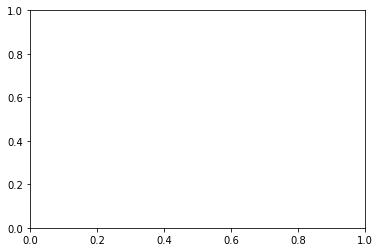

In [334]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots()

ax.plot(x_predict, phi_analytic, 'bo-', label="analytic sol") 
ax.plot(x_predict, phi_predict_network, 'r*-', label="predict sol")

ax.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)

ax.set_ylabel('phi Value')
ax.set_xlabel('X - axis')
ax.grid()
plt.savefig('ANN_for_ODE.png')
plt.show()

In [276]:
t = tf.constant([ [[1, 1, 1], [2, 2, 2]], [[3, 3, 3], [4, 4, 4]] ])
t


<tf.Tensor: shape=(2, 2, 3), dtype=int32, numpy=
array([[[1, 1, 1],
        [2, 2, 2]],

       [[3, 3, 3],
        [4, 4, 4]]])>

In [548]:
x = tf.constant([1,2,3])
y = tf.constant([3,2,1])

x*y

<tf.Tensor: shape=(3,), dtype=int32, numpy=array([3, 4, 3])>

In [26]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Define Sequential model with 3 layers
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)
# Call model on a test input
x = tf.ones((1, 3))
y = model(x)
# y
y.op

AttributeError: Tensor.op is meaningless when eager execution is enabled.

In [2]:
print(len(model.layers)) 

3


In [27]:
encoder_input = keras.Input(shape=(28, 28, 1), name="original_img")
x = layers.Conv2D(16, 3, activation="relu")(encoder_input)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.MaxPooling2D(3)(x)
x = layers.Conv2D(32, 3, activation="relu")(x)
x = layers.Conv2D(16, 3, activation="relu")(x)
encoder_output = layers.GlobalMaxPooling2D()(x)

encoder = keras.Model(encoder_input, encoder_output, name="encoder")
# encoder.summary()

decoder_input = keras.Input(shape=(16,), name="encoded_img")
x = layers.Reshape((4, 4, 1))(decoder_input)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu")(x)
x = layers.UpSampling2D(3)(x)
x = layers.Conv2DTranspose(16, 3, activation="relu")(x)
decoder_output = layers.Conv2DTranspose(1, 3, activation="relu")(x)

decoder = keras.Model(decoder_input, decoder_output, name="decoder")
# decoder.summary()

autoencoder_input = keras.Input(shape=(28, 28, 1), name="img")
encoded_img = encoder(autoencoder_input)
decoded_img = decoder(encoded_img)
autoencoder = keras.Model(autoencoder_input, decoded_img, name="autoencoder")
# autoencoder.summary()
encoded_img.op

<tf.Operation 'encoder/global_max_pooling2d_7/Max' type=Max>

In [64]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data (these are NumPy arrays)
x_train = x_train.reshape(60000, 784).astype("float32") / 255
x_test = x_test.reshape(10000, 784).astype("float32") / 255

y_train = y_train.astype("float32")
y_test = y_test.astype("float32")

# Reserve 10,000 samples for validation
x_val = x_train[-10000:]
y_val = y_train[-10000:]
x_train = x_train[:-10000]
y_train = y_train[:-10000]

def get_uncompiled_model():
    inputs = tf.keras.Input(shape=(784,), name="digits")
    x = tf.keras.layers.Dense(64, activation="relu", name="dense_1")(inputs)
    x = tf.keras.layers.Dense(64, activation="relu", name="dense_2")(x)
    outputs =  tf.keras.layers.Dense(10, activation="softmax", name="predictions")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model


class CategoricalTruePositives(tf.keras.metrics.Metric):
    def __init__(self, name="dddddddeqewrqwe", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)
        self.true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.reshape(tf.argmax(y_pred, axis=1), shape=(-1, 1))
        values = tf.cast(y_true, "int32") == tf.cast(y_pred, "int32")
        values = tf.cast(values, "float32")
        if sample_weight is not None:
            sample_weight = tf.cast(sample_weight, "float32")
            values = tf.multiply(values, sample_weight)
        self.true_positives.assign_add(tf.reduce_sum(values))

    def result(self):
        return self.true_positives

    def reset_states(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.0)


model = get_uncompiled_model()
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=[ODE_Metric()],
)
model.fit(x_train, y_train, batch_size=64, epochs=1)

for m in model.metrics:
    tf.print(m.name) 
            

782/782 [==============================] - 1s 2ms/step - loss: 0.3337 - ODE_Metric: 0.0000e+00
loss
ODE_Metric
